In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('../definitions')
import def_model as mod_def

Select Dates

In [2]:
start_date = pd.Timestamp('2024-03-22')
end_date = pd.Timestamp('2024-03-30')

Import Data

In [3]:
# df = mod_def.combine_resampled_data(start_date, end_date)
df = pd.read_csv("/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/MIN DATA/mean_of_five_data.csv", index_col=0).dropna()
print(df.head())
print(df.shape)

   NS_SQUID   Z_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate  H Component
0 -0.241607  0.037413     0.060228     1.587244    0.539145     1.588387
1 -0.241438  0.037316     0.061372     1.585839    0.540146     1.587026
2 -0.241561  0.037240     0.061161     1.584446    0.543552     1.585626
3 -0.241551  0.037335     0.061358     1.584793    0.540371     1.585981
4 -0.241554  0.037822     0.062437     1.569843    0.540531     1.571084
(294117, 6)


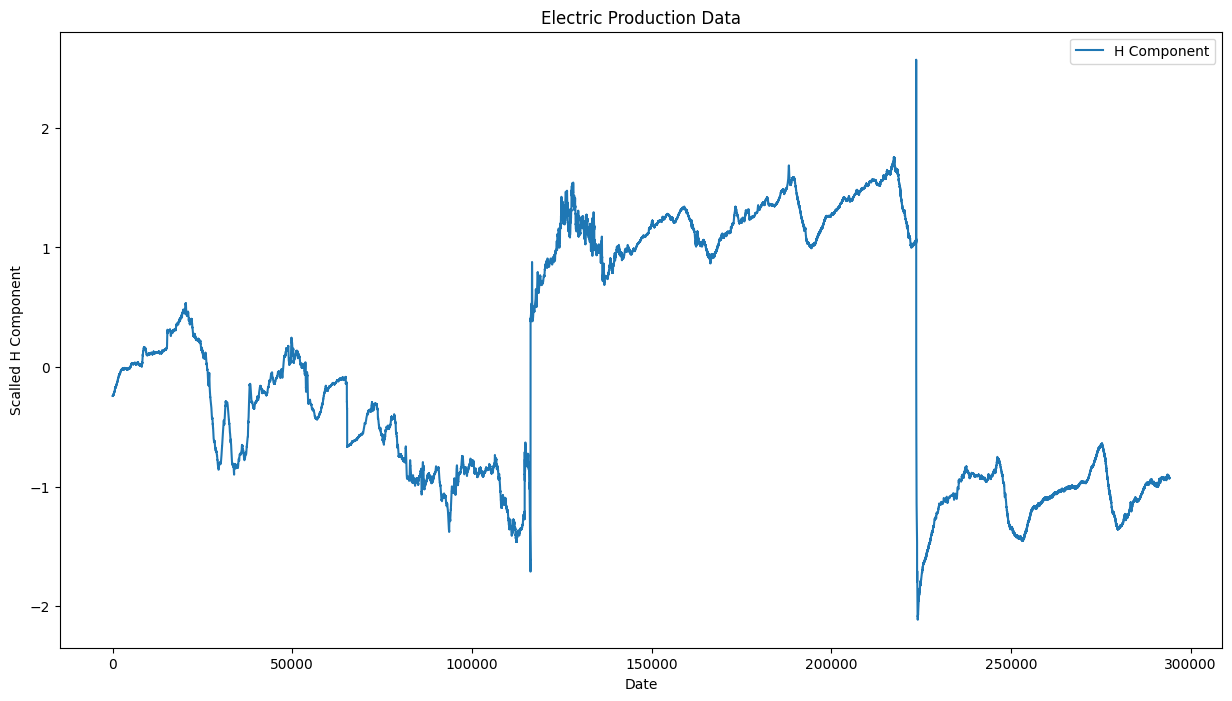

In [4]:
# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['NS_SQUID'], label='H Component')
plt.xlabel('Date')
plt.ylabel('Scalled H Component')
plt.title('Electric Production Data')
plt.legend()
plt.show()

# Create training and testing datasets

In [5]:
# train_start_dt = pd.Timestamp('2024-03-22')
# test_start_dt = pd.Timestamp('2024-03-27')
df = df[df.columns[1:6]]
print(df.head())
print(type(df))
train = df.loc[0:60000]
test = df.loc[60000:]



    Z_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate  H Component
0  0.037413     0.060228     1.587244    0.539145     1.588387
1  0.037316     0.061372     1.585839    0.540146     1.587026
2  0.037240     0.061161     1.584446    0.543552     1.585626
3  0.037335     0.061358     1.584793    0.540371     1.585981
4  0.037822     0.062437     1.569843    0.540531     1.571084
<class 'pandas.core.frame.DataFrame'>


Scaling

In [6]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
# print(train_scaled)
# print(test_scaled)

Prep for training

In [7]:
def create_dataset(X, y, time_steps=1):
    """Creates a dataset for time series forecasting from a multidimensional DataFrame.

    Args:
        X: Input DataFrame.
        y: Target series.
        time_steps: Number of time steps to consider for each sample.

    Returns:
        A tuple of the input and target datasets.
    """

    # Ensure that X and y have the same shape
    # assert X.shape[0] == y.shape[0], "X and y must have the same number of rows."

    # Xs, ys = [], []
    # for i in range(len(X) - time_steps):
    #     # Extract a window of data, preserving dimensions
    #     v = X.iloc[i:i + time_steps]
    #     Xs.append(v.values)
    #     ys.append(y[i + time_steps])
    # return np.array(Xs), np.array(ys)
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 5
X_train, y_train = create_dataset(train_scaled, train_scaled, TIME_STEPS)
X_test, y_test = create_dataset(test_scaled, test_scaled, TIME_STEPS)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(59996, 5, 5) (59996, 5)
(234112, 5, 5) (234112, 5)


SVR Model

In [8]:
model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon=0.05)
# Fit the model
model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

ValueError: Found input variables with inconsistent numbers of samples: [59996, 299980]

Make Predictions

In [12]:
# Make predictions
train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Inverse scaling
train_pred_inv = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_inv = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

Model Evaluation

In [13]:
# Evaluate the model
mse_train = mean_squared_error(y_train_inv, train_pred_inv)
mse_test = mean_squared_error(y_test_inv, test_pred_inv)
print("Mean Squared Error on Training Data:", mse_train)
print("Mean Squared Error on Testing Data:", mse_test)

Mean Squared Error on Training Data: 0.00901404349576742
Mean Squared Error on Testing Data: 0.008263857318303909


Visualization

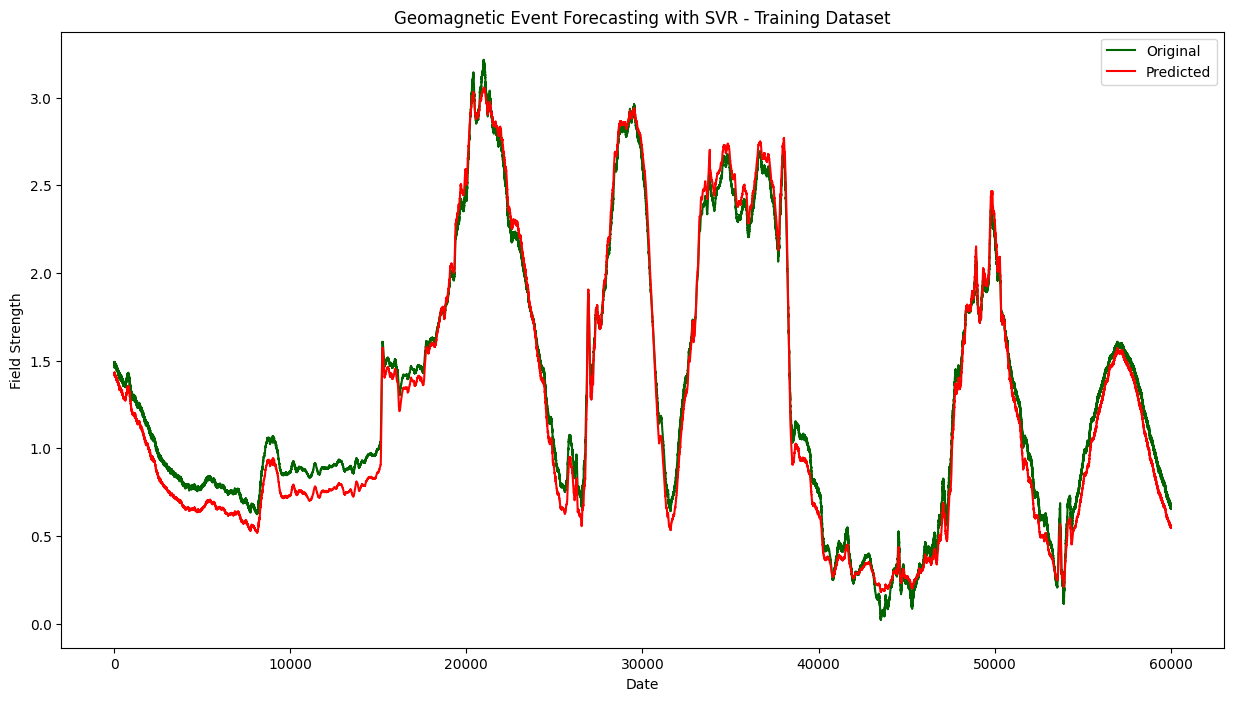

In [14]:
# Plotting the results for train dataset
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], y_train_inv, label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], train_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Field Strength')
plt.title('Geomagnetic Event Forecasting with SVR - Training Dataset')
plt.legend()
plt.show()

Plot the forcasted graph

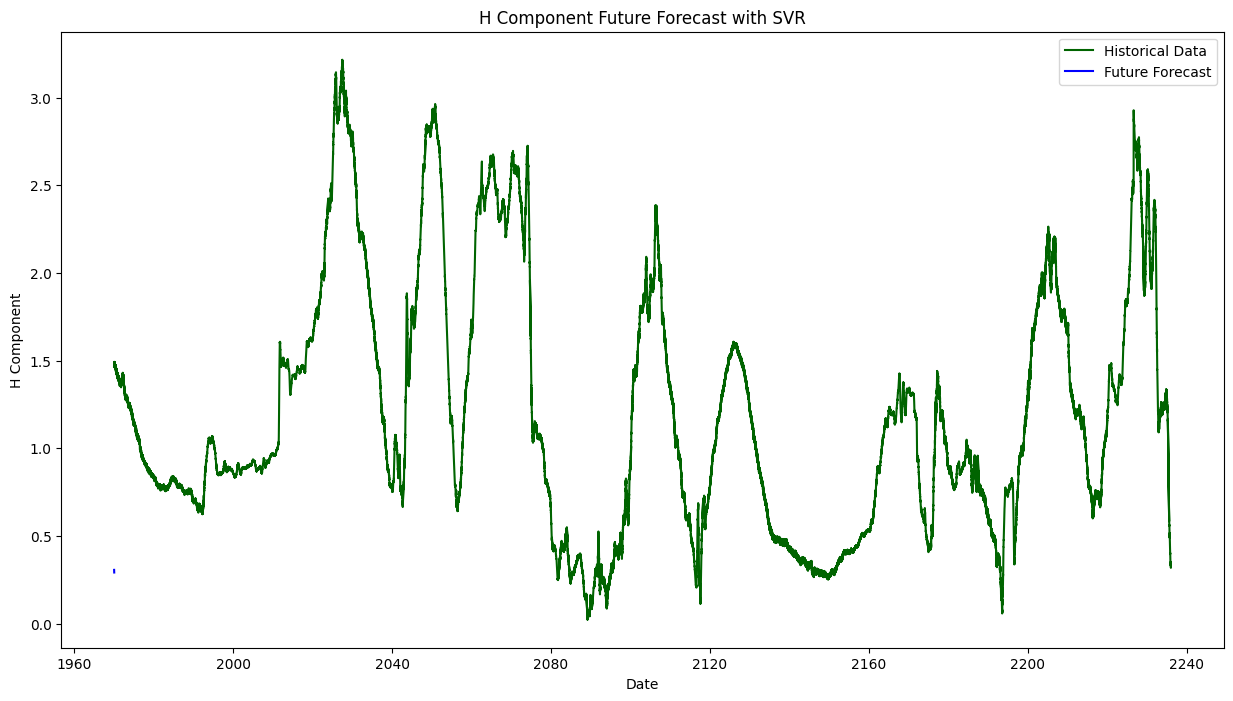

In [15]:
# Number of future time steps to forecast
future_steps = 10  # Adjust this as needed

# Last `TIME_STEPS` values from the test set to start forecasting
last_sequence = X_test[-1]

# Forecast future values
future_forecast = []
for _ in range(future_steps):
    # Predict next value based on the last sequence
    next_pred = model.predict(last_sequence.reshape(1, -1))
    future_forecast.append(next_pred[0])
    # Update the last sequence by removing the first element and adding the predicted value
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

# Inverse scaling for future forecast
future_forecast_inv = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Generate future timestamps
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='D')[1:]

# Plotting the future forecast
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['H Component'], label='Historical Data', color='darkgreen')
plt.plot(future_dates, future_forecast_inv, label='Future Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('H Component')
plt.title('H Component Future Forecast with SVR')
plt.legend()
plt.show()